<a href="https://colab.research.google.com/github/DrAlexSanz/predicting-user-behavior-workshop/blob/main/ALEX_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torch import Tensor
import torch.nn.functional as F

!pip install torch_geometric
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install torchviz
!pip install matplotlib


import torch_geometric.transforms as T
from torch_geometric.data import HeteroData
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.nn import SAGEConv, to_hetero

Found existing installation: torch_scatter 2.1.2+pt22cu121
Uninstalling torch_scatter-2.1.2+pt22cu121:
  Successfully uninstalled torch_scatter-2.1.2+pt22cu121
Found existing installation: torch_sparse 0.6.18+pt22cu121
Uninstalling torch_sparse-0.6.18+pt22cu121:
  Successfully uninstalled torch_sparse-0.6.18+pt22cu121
Found existing installation: torch_geometric 2.6.0
Uninstalling torch_geometric-2.6.0:
  Successfully uninstalled torch_geometric-2.6.0
Found existing installation: torch_cluster 1.6.3+pt22cu121
Uninstalling torch_cluster-1.6.3+pt22cu121:
  Successfully uninstalled torch_cluster-1.6.3+pt22cu121
Looking in links: https://data.pyg.org/whl/torch-2.2.1+cu121.html
  Using cached https://data.pyg.org/whl/torch-2.2.0%2Bcu121/torch_scatter-2.1.2%2Bpt22cu121-cp310-cp310-linux_x86_64.whl (10.9 MB)
Looking in links: https://data.pyg.org/whl/torch-2.2.1+cu121.html
  Using cached https://data.pyg.org/whl/torch-2.2.0%2Bcu121/torch_sparse-0.6.18%2Bpt22cu121-cp310-cp310-linux_x86_64.whl 

In [2]:
!git clone https://github.com/Synerise/predicting-user-behavior-workshop.git
DATA_DIR = "./predicting-user-behavior-workshop/data"

fatal: destination path 'predicting-user-behavior-workshop' already exists and is not an empty directory.


In [3]:
TRAIN_PD_PATH = f"{DATA_DIR}/2019-Oct_small.csv"
TARGETS_PD_PATH = f"{DATA_DIR}/2019-Nov_train_target.csv"
TEST_TARGETS_PATH = f"{DATA_DIR}/test_target.npy"
TARGET_LABELS = f'{DATA_DIR}/target_brands.npy'
USER_IDS = f'{DATA_DIR}/user_ids.npy'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

Device: 'cuda'


In [5]:
def load_data():
    train_df = pd.read_csv(TRAIN_PD_PATH)
    target_df = pd.read_csv(TARGETS_PD_PATH)
    test_targets_np = np.load(TEST_TARGETS_PATH)
    target_labels = np.load(TARGET_LABELS, allow_pickle=True)
    user_ids = np.load(USER_IDS)

    return train_df, target_df, test_targets_np, target_labels, user_ids

In [6]:
train_df, target_df, targets, target_labels, users_in_target = load_data()

In [7]:
train_df

,event_time,brand,user_id
0,2019-10-01 00:02:14 UTC,samsung,543272936
1,2019-10-01 00:04:37 UTC,apple,551377651
2,2019-10-01 00:05:14 UTC,xiaomi,550121407
3,2019-10-01 00:06:02 UTC,xiaomi,514591159
4,2019-10-01 00:07:07 UTC,santeri,555332717
...,...,...,...
1592249,2019-10-31 23:55:21 UTC,puckator,514622109
1592250,2019-10-31 23:56:03 UTC,apple,512717356
1592251,2019-10-31 23:56:11 UTC,apple,533892594
1592252,2019-10-31 23:56:53 UTC,apple,533892594


In [8]:
target_df = target_df[target_df['user_id'].isin(train_df['user_id'].unique())]

In [9]:
train_df = pd.concat([train_df, target_df])

# Create artificial IDs for users and brands
In a few moments we'll be using the PyG library. We must create some objects required by the library to represent our graph. First, we will map users and brands to artificial integer IDs.

In [10]:
users_in_target.shape, train_df['user_id'].nunique()

((458835,), 458835)

In [11]:
unique_user_ids = pd.DataFrame(data={
    'user_id': users_in_target,
    'mapped_user_id': pd.RangeIndex(len(users_in_target)),
})
print("Mapping of user IDs to consecutive values:")
print("==========================================")
print(unique_user_ids.head())
print()

Mapping of user IDs to consecutive values:
     user_id  mapped_user_id
0  264649825               0
1  284344819               1
2  293957954               2
3  303160429               3
4  304325717               4



In [12]:
unique_brands = train_df['brand'].unique()
unique_brands = pd.DataFrame(data={
    'brand': unique_brands,
    'mapped_brand': pd.RangeIndex(len(unique_brands)),
})
print("Mapping of brands to consecutive values:")
print("===========================================")
print(unique_brands)

Mapping of brands to consecutive values:
          brand  mapped_brand
0       samsung             0
1         apple             1
2        xiaomi             2
3       santeri             3
4         oasis             4
...         ...           ...
2084      elite          2084
2085  ciaobimbi          2085
2086        mtx          2086
2087   babycare          2087
2088    joonies          2088

[2089 rows x 2 columns]


Next, we merge the IDs with our dataset:

In [13]:
purchases_user_id = pd.merge(train_df['user_id'], unique_user_ids,
                            left_on='user_id', right_on='user_id', how='left')
purchases_brand = pd.merge(train_df['brand'], unique_brands,
                            left_on='brand', right_on='brand', how='left')

We switch to representing our graph by only the artificial IDs, by taking matching user ID and brand ID of each transaction:

In [14]:
purchases_user_id = torch.from_numpy(purchases_user_id['mapped_user_id'].values)
purchases_brand = torch.from_numpy(purchases_brand['mapped_brand'].values)

# Create the HeteroData object
Now, we finally create the native PyG object representing our graph. It's called HeteroData because we have a few different node types inside the graph. First, we merge the matching user and brand ids into a 2d numpy array:

In [15]:
edge_index_user_to_brand = torch.stack([purchases_user_id, purchases_brand], dim=0)

print("Final edge indices pointing from users to brands:")
print("=================================================")
print(edge_index_user_to_brand)

Final edge indices pointing from users to brands:
tensor([[269291, 318410, 311172,  ..., 369565, 226688, 219058],
        [     0,      1,      2,  ...,      0,      0,     89]])


Then, we create an undirected HeteroData object. We need to name the main relationship between users and brands. We call it buys to reflect the relationship "user A buys brand B".

In [16]:
num_users = len(unique_user_ids)
num_brands = len(unique_brands)

data = HeteroData()
data["user"].node_id = torch.arange(num_users)
data["brand"].node_id = torch.arange(num_brands)

#give some name to the relationship between user nodes and brand nodes
data["user", "buys", "brand"].edge_index = edge_index_user_to_brand
data = T.ToUndirected()(data)

# Visualize the Graph with networkx

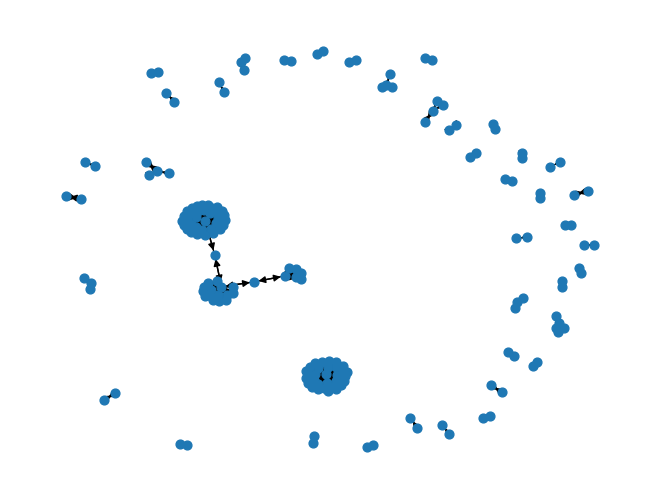

In [17]:
import networkx as nx

subgraph = edge_index_user_to_brand[:, :200].T.numpy()

user2name = {x:f'user{x}' for x in subgraph[:, 0]}
brand2name = {x:f'brand{x}' for x in subgraph[:, 1]}

named_subgraph = [(user2name[start], brand2name[end]) for start, end in subgraph]

g = nx.from_edgelist(named_subgraph)
g = nx.DiGraph(g)

nx.draw(g, node_size=40)

In [18]:
g.nodes

NodeView(('user269291', 'brand0', 'user318410', 'brand1', 'user311172', 'brand2', 'user66925', 'user344786', 'brand3', 'user180805', 'user179240', 'user302537', 'brand4', 'user221216', 'user342836', 'brand5', 'user233498', 'user81999', 'user99290', 'brand6', 'user343384', 'user43721', 'brand7', 'user342935', 'user113953', 'user8963', 'brand8', 'user253124', 'user49754', 'user99592', 'user343464', 'user40345', 'brand9', 'user109999', 'brand10', 'user149124', 'user151673', 'brand11', 'user308368', 'user84186', 'user27744', 'brand12', 'user55764', 'brand13', 'user339275', 'user72390', 'brand14', 'user74104', 'brand15', 'user16440', 'user18475', 'user168697', 'brand16', 'user311318', 'user129158', 'brand17', 'user317750', 'brand18', 'user33481', 'user14872', 'user177993', 'user68783', 'user145217', 'user138147', 'user97116', 'user232615', 'user311751', 'user345441', 'user129751', 'brand19', 'user345439', 'user323176', 'user63683', 'user295264', 'user97389', 'brand20', 'user171332', 'brand2

# Exercise 1
We want to color the nodes to show which are USERS, and which are BRANDS. Create a `color_map` list with strings: 'red' for users, and 'green' for brands, to match the ordering of USER and BRAND nodes in `g.nodes` above.

The result should look like this: `color_map = ('green', 'red', 'green', 'red', ...)`

In [19]:
color_map = ['green' if x.startswith('brand') else 'red' for x in g.nodes]

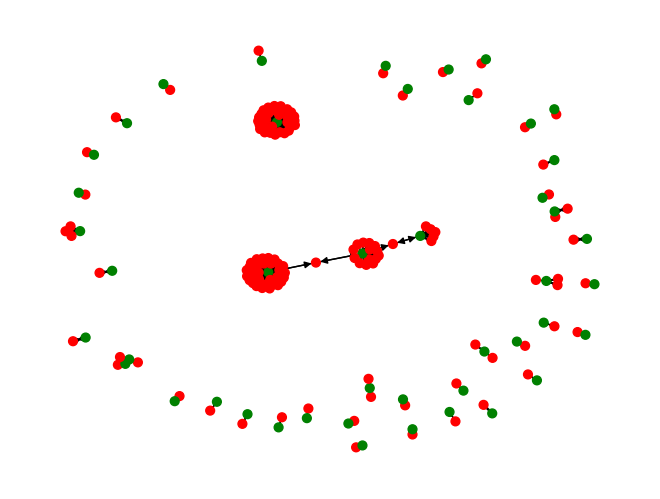

In [20]:
#BRANDS are GREEN
#USERS are RED
nx.draw(g, node_size=40, node_color=color_map)

# Define the Splits
Now, we need to define how our data will be split during training:

* `num_val` - what portion of the graph we want to validate on during training
* `num_test` - what portion of the graph we want to use for testing (it's 0.0 because we want to do a full prediction for all users during test)
* `disjoint_train_ratio=0.3` - 30% of edges will be used as training targets (0 or 1 values will teach the model whether it should predict an edge or not between a given pair of nodes). 70% of edges will be used for aggregating neighbors and walking over the graph.
* `neg_sampling_ratio=2.0` - non-existent edges will be created as well (to be used as negative examples during validation) with a ratio of 2 non-existent edges to 1 existing edge
* `add_negative_train_samples=False` - negative edges during training will not be generated beforehand, but will be generated on-the-fly
* `edge_types` - our chosen name for the user-brand relationship
* `rev_edge_types` - we want to go from users to brands, but also from brands to users (two-way connections in the graph). We call it a reverse buy operation

In [21]:
transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.0,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=2.0,
    add_negative_train_samples=False,
    edge_types=("user", "buys", "brand"),
    rev_edge_types=("brand", "rev_buys", "user"),
)
train_data, val_data, _ = transform(data)

In [22]:
train_data

HeteroData(
  user={ node_id=[458835] },
  brand={ node_id=[2089] },
  (user, buys, brand)={
    edge_index=[2, 1081202],
    edge_label=[463371],
    edge_label_index=[2, 463371],
  },
  (brand, rev_buys, user)={ edge_index=[2, 1081202] }
)

# Define the Loader
We must also create a dataloader to generate training batches of the data. Neural networks rarely accept the whole dataset at once. More often, they gradually update their weights using portions of data (batches) until the whole dataset is processed.

Some important parameters to give here:

* `num_neighbors` - select max number of first-order neighbors and second-order neighbors
* `neg_sampling_ratio` - similarly as before - define how many artificial negative edges should be generated for training.
* `batch_size` - how many nodes (with their neighborhoods) we want to accept into the neural network in a given time
* `shuffle=True` - we want to mix the ordering of training examples (it is shown to improve neural network quality)

In [23]:
edge_label_index = train_data["user", "buys", "brand"].edge_label_index
edge_label = train_data["user", "buys", "brand"].edge_label
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[5, 5],
    neg_sampling_ratio=2.0,
    edge_label_index=(("user", "buys", "brand"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True,
)

/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


# Create the GNN Architecture

In [24]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        """
        Defines the architecture of our GNN, such as the type and number of layers.
        """
        super().__init__()
        #create 2 GraphSAGE layers:
        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.num_users = data["user"].num_nodes
        self.num_brands = data["brand"].num_nodes

        #create untrained Embedding objects for users and brands. These embeddings will start to change during network training.
        self.user_emb = torch.nn.Embedding(self.num_users, hidden_channels)
        self.brand_emb = torch.nn.Embedding(self.num_brands, hidden_channels)
        # Instantiate a homogeneous GNN:
        self.gnn = GNN(hidden_channels)
        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())

    def forward(self, data: HeteroData) -> Tensor:
        edge_label_index = data["user", "buys", "brand"].edge_label_index

        x_dict = self.encode(data)
        pred = self.decode(x_dict["user"], x_dict["brand"], edge_label_index)
        return pred

    def encode(self, data: HeteroData) -> Tensor:
        """
        Takes a HeteroData object (so, our graph or a part of it) and runs it thought our GNN.
        We obtain a dictionary of node embeddings.
        """
        x_dict = {
          "user": self.user_emb(data["user"].node_id),
          "brand": self.brand_emb(data["brand"].node_id),
        }
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        return x_dict

    def decode(self, x_user: Tensor, x_brand: Tensor, edge_label_index: np.array) -> Tensor:
        """
        Computes similarity between given user and brand embeddings.
        Similarity defines the "relatedness" of a given user with a given brand.
        """
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_brand = x_brand[edge_label_index[1]]
        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_user * edge_feat_brand).sum(dim=-1)

model = Model(hidden_channels=32)

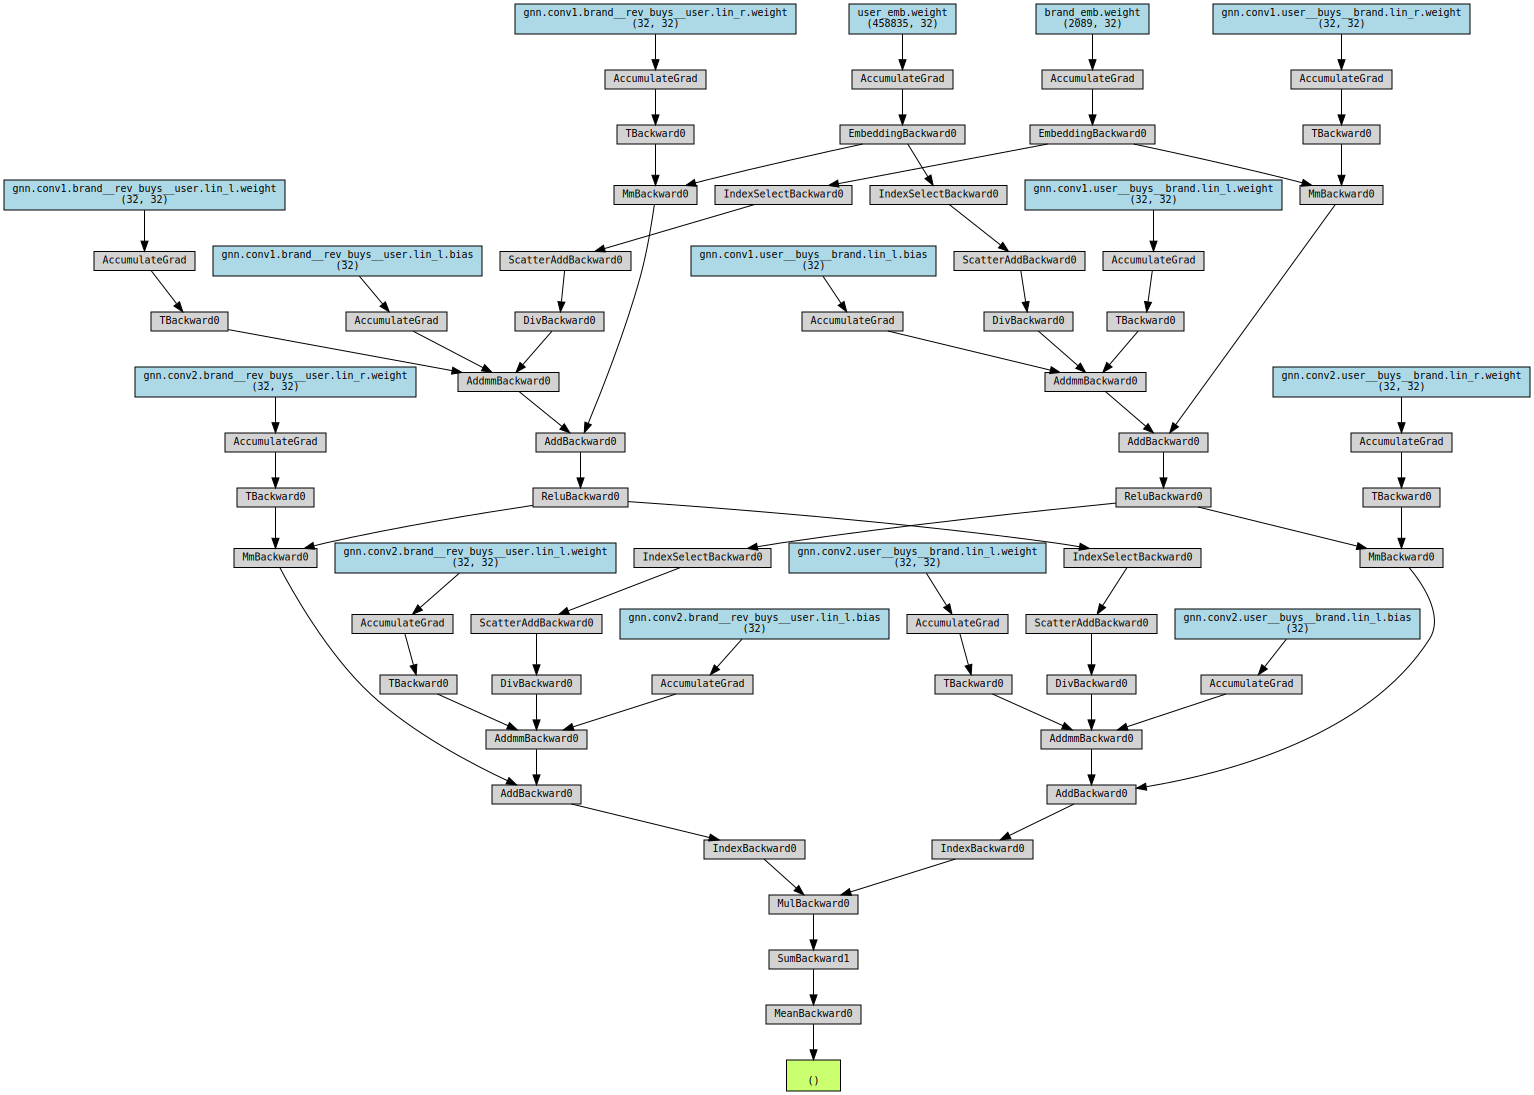

In [25]:
from torchviz import make_dot


batch = next(iter(train_loader))
y = model(batch)

make_dot(y.mean(), params=dict(model.named_parameters()))

# Training
We train the model on a **link prediction** task. The training objective is to predict whether there is an edge between given nodes.

In [26]:
import tqdm
import torch.nn.functional as F

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(10):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        sampled_data.to(device)
        pred = model(sampled_data)
        ground_truth = sampled_data["user", "buys", "brand"].edge_label

        #this is a loss function for binary classification (0 = no edge between nodes exists, 1 = an edge between nodes exists)
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch}, Loss: {total_loss / total_examples:.4f}")

100%|██████████| 3621/3621 [01:10<00:00, 51.73it/s]


Epoch: 0, Loss: 0.1266


100%|██████████| 3621/3621 [01:02<00:00, 57.79it/s]


Epoch: 1, Loss: 0.0992


100%|██████████| 3621/3621 [01:02<00:00, 58.34it/s]


Epoch: 2, Loss: 0.0944


100%|██████████| 3621/3621 [01:02<00:00, 58.26it/s]


Epoch: 3, Loss: 0.0906


100%|██████████| 3621/3621 [01:01<00:00, 58.42it/s]


Epoch: 4, Loss: 0.0872


100%|██████████| 3621/3621 [01:02<00:00, 58.30it/s]


Epoch: 5, Loss: 0.0831


100%|██████████| 3621/3621 [01:01<00:00, 58.87it/s]


Epoch: 6, Loss: 0.0786


100%|██████████| 3621/3621 [01:00<00:00, 59.40it/s]


Epoch: 7, Loss: 0.0745


100%|██████████| 3621/3621 [01:01<00:00, 59.20it/s]


Epoch: 8, Loss: 0.0702


100%|██████████| 3621/3621 [01:01<00:00, 59.15it/s]

Epoch: 9, Loss: 0.0659


In [27]:
brand_dict = dict(zip(unique_brands['brand'].values, unique_brands['mapped_brand'].values))
target_brand_ids = [brand_dict[brand] for brand in target_labels]

In [28]:
target_brand_ids

[0, 1, 2, 7, 45, 33, 43, 44, 15, 41, 62, 28, 91, 47, 24, 72, 57, 38, 96, 73]

# Testing
For testing, we need to create a new loader with no negative edges. We want to gather the trained embeddings of all users and brands.

Note that these embeddings are **NOT** the nn.Embeddings objects. Rather, we want to get the vectors which originate after running our HeteroData through our GraphSAGE network. We treat these vectors as final, trained user and brand embeddings.

In [29]:
batch_size = 128

train_loader_for_preds = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20, 10],
    neg_sampling_ratio=0.0,
    edge_label_index=(("user", "buys", "brand"), edge_label_index),
    edge_label=edge_label,
    batch_size=batch_size,
    shuffle=False,
)

/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [30]:
from sklearn.metrics import roc_auc_score

user_ids_set = set()
user_ids = []
user_emb = []

brand_ids_set = set()
brand_ids = []
brand_emb = []

for sampled_data in tqdm.tqdm(train_loader_for_preds):
    with torch.no_grad():
        sampled_data.to(device)
        x_dict = model.encode(sampled_data)

        u_ids = sampled_data["user"].node_id
        b_ids = sampled_data["brand"].node_id

        user_embeddings = x_dict["user"]
        brand_embeddings = x_dict["brand"]

        for u_id, u_emb in zip(u_ids, user_embeddings):
            if u_id not in user_ids_set:
                user_ids.append(u_id)
                user_emb.append(u_emb)
                user_ids_set.add(u_id)

        for b_id, b_emb in zip(b_ids, brand_embeddings):
            if b_id not in brand_ids_set:
                brand_ids.append(b_id)
                brand_emb.append(b_emb)
                brand_ids_set.add(b_id)

100%|██████████| 3621/3621 [01:15<00:00, 47.94it/s]


In [31]:
target_brand_embeddings = [brand_emb[brand_ids.index(b_id)] for b_id in target_brand_ids]

In [32]:
target_brand_embeddings = torch.stack(target_brand_embeddings).cpu()
user_embeddings = torch.stack(user_emb).cpu()

In [33]:
user_ids = torch.tensor(user_ids, device = 'cpu')

# Get the Final Predictions
To get user and brand "relatedness" scores, we perform a dot product - similarly as during training. A high dot product value for a (user, brand) pair signifies a high relatedness.

In [34]:
preds = torch.matmul(user_embeddings, target_brand_embeddings.T.cpu()).sigmoid()

In [35]:
ground_truths = targets[user_ids]

In [36]:
auc = roc_auc_score(ground_truths, preds)
print(f"Validation AUC: {auc:.4f}")

Validation AUC: 0.7435
